# Advertising Sales (Advertising Dataset)
- Difficulty: Beginner → Intermediate
- Project Purpose: Predict sales from ad spend (TV, Radio, Newspaper); stretch → add ElasticNet, tune α, visualize performance.
- Points Examined: OLS, Ridge, Lasso, ElasticNet, grid search.
- Doc References: Elastic Net.
- Why Useful: One dataset → all regression types compared side-by-side.


# Part 1 Data retrieval

In [26]:
import pandas as pd
import numpy as np
from sklearn import metrics, model_selection, linear_model
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
%matplotlib inline

In [27]:
! mkdir adv
!curl -L -o ./adv/advertising-sales-dataset.zip https://www.kaggle.com/api/v1/datasets/download/yasserh/advertising-sales-dataset

mkdir: adv: File exists
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0--:-- --:--:-- --:--:--     0
100  2302  100  2302    0     0   2196      0  0:00:01  0:00:01 --:--:--  2196


In [28]:
data = pd.read_csv('./adv/advertising-sales-dataset.zip')

In [29]:
data.head()

,Unnamed: 0,TV Ad Budget ($),Radio Ad Budget ($),Newspaper Ad Budget ($),Sales ($)
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


# Part 2 Hypothesis

Here, we try to use linear regression, l1, l2, elastic-net for regression. And we have the following assumption for the data:
1. For all different sources, the ad budget will have a linear relationship with sales.
2. All of those ads are positively related to sales (i.e. no negative effects), while they have different strength related to sales.

In order to verify point 1, we need to fit the model to linear models, together with different regularizations, after that, we will print residual value as different axis as well as predicted value and check the distribution to ensure that the linear relationship hypothesis.

In order to verify point 2, we will first scale the dataset for better l1, l2, elastic-net performance, after that, we will compare the (coefficient / scaler factor). This is because we want to some how measure budget/sales rate for each ads, and scaler will likely to bring coefficient large (if we scale by divided by x, then coefficient will be x times lager could be wrong.)

Lastly, we will do learning curve, to see if we are overfitting, and if the original training is just a lucky split somehow.

# Part 3 Data Cleaning

In [30]:
print(data.isnull().sum())
# woo yay, we got a perfect dataset

Unnamed: 0                 0
TV Ad Budget ($)           0
Radio Ad Budget ($)        0
Newspaper Ad Budget ($)    0
Sales ($)                  0
dtype: int64


In [31]:
X = data.iloc[:, 1:-1] # first colum seems to be like index so drop
y = data.iloc[:, -1]

In [32]:
# This time we will include standard scaler in the model as pipeline, so we will not include standard scaling here

# Part 4 Train Test Split

In [48]:
from sklearn.model_selection import train_test_split, learning_curve

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Part 5 Model Training - OLS, L1, L2, Elastic-Net

In [52]:
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline

ols = Pipeline([
    ('scaler', StandardScaler()),
    ('ols', LinearRegression())
])

lasso = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', LassoCV())
])

ridge = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', RidgeCV())
])

elasticnet = Pipeline([
    ('scaler', StandardScaler()),
    ('elasticnet', ElasticNetCV())
])

In [53]:
ols.fit(X_train, y_train)
lasso.fit(X_train, y_train)
ridge.fit(X_train, y_train)
elasticnet.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('elasticnet', ElasticNetCV())])

In [54]:
from sklearn.metrics import r2_score
print(f"R2 for ols is {r2_score(y_train, ols.predict(X_train))}")
print(f"R2 for lasso is {r2_score(y_train, lasso.predict(X_train))}")
print(f"R2 for ridge is {r2_score(y_train, ridge.predict(X_train))}")
print(f"R2 for elasticnet is {r2_score(y_train, elasticnet.predict(X_train))}")

R2 for ols is 0.8957008271017818
R2 for lasso is 0.8953811304242034
R2 for ridge is 0.8957004943782227
R2 for elasticnet is 0.8956459008706583


In [67]:
# This is a bit too good, 0.89 means this almost very certain that we are getting a good linear model.
# Let's print the residual verse different factor/predicted value to see if error increase as feature shift somewhere, which might suggest there are some missing polynomial feature not getting picked up.

def print_residuals(model, X_test, y_test):
    plt.figure(figsize=(15,6))

    # Print y_pred against y_test
    y_pred = model.predict(X_test)
    residuals = y_test - y_pred

    plt.subplot(1, 4, 1)
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(y=0, color='r')
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.title("Residuals vs Predicted")


    X_test_scaled = model['scaler'].transform(X_test)
    tv_x, radio_x, newspaper_x = X_test_scaled[:, 0], X_test_scaled[:, 1], X_test_scaled[:, 2]

    # tv
    plt.subplot(1, 4, 2)
    sns.scatterplot(x=tv_x, y=residuals)
    plt.axhline(y=0, color='r')
    plt.xlabel("TV ad Budget")
    plt.ylabel("Residuals")
    plt.title("TV ad Budget vs Residuals")

    # Radio ad budget
    plt.subplot(1, 4, 3)
    sns.scatterplot(x=radio_x, y=residuals)
    plt.axhline(y=0, color='r')
    plt.xlabel("Radio ad Budget")
    plt.ylabel("Residuals")
    plt.title("Radio ad Budget vs Residuals")

    # Newspaper ad budget
    plt.subplot(1, 4, 4)
    sns.scatterplot(x=newspaper_x, y=residuals)
    plt.axhline(y=0, color='r')
    plt.xlabel("Newspaper ad Budget")
    plt.ylabel("Residuals")
    plt.title("Newspaper ad Budget vs Residuals")



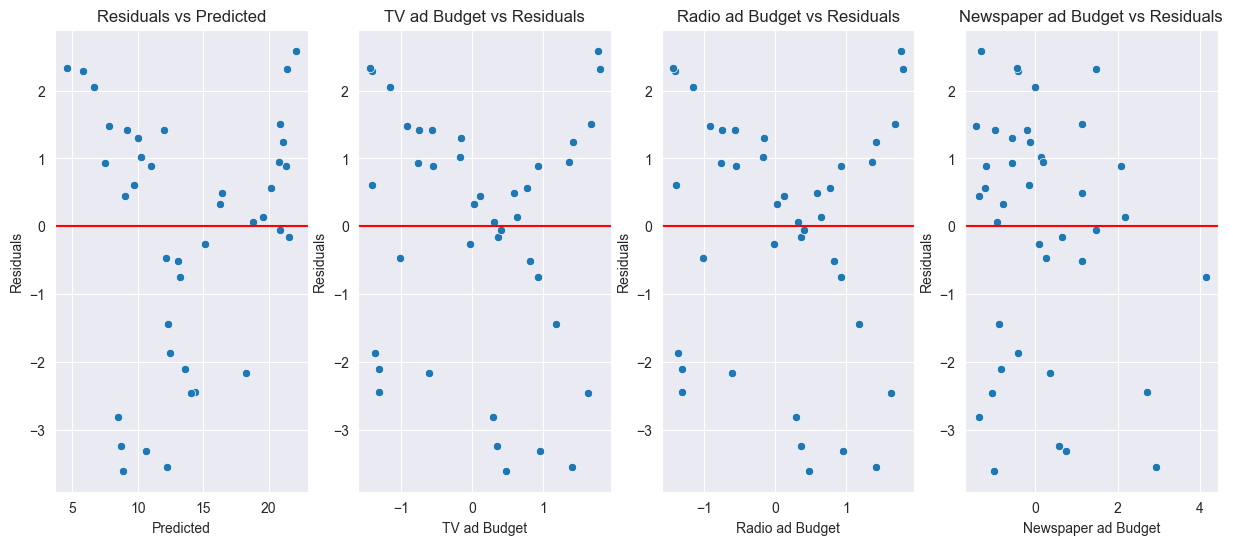

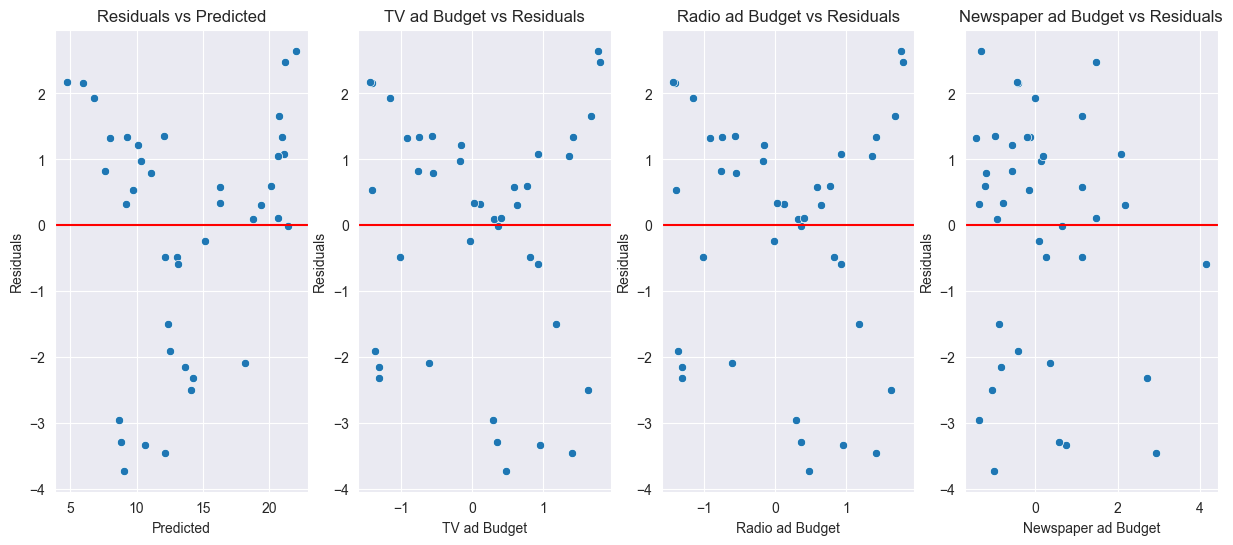

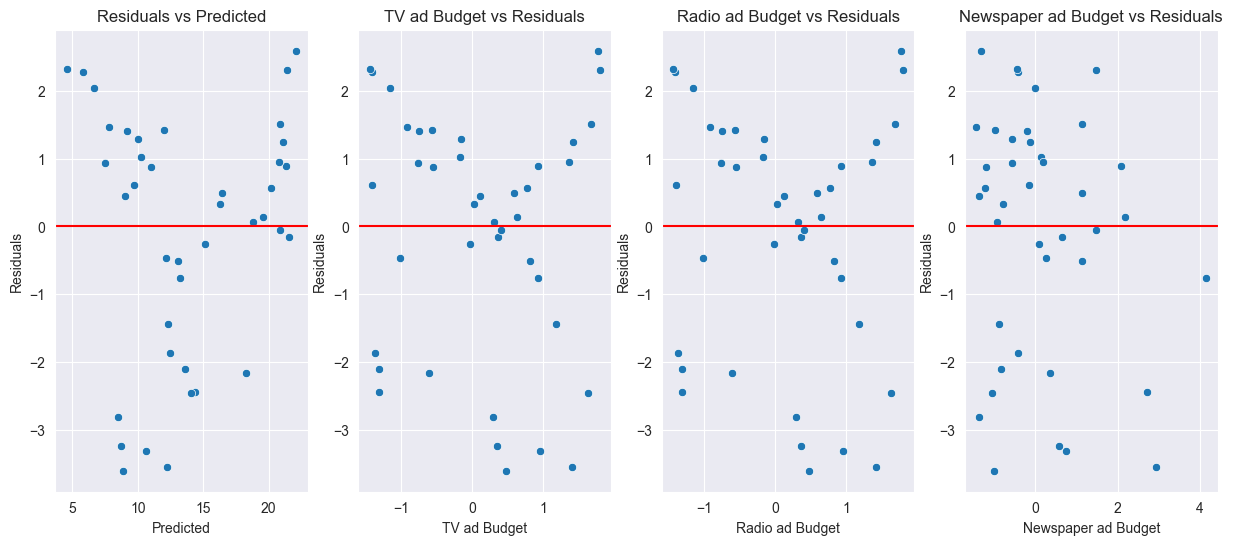

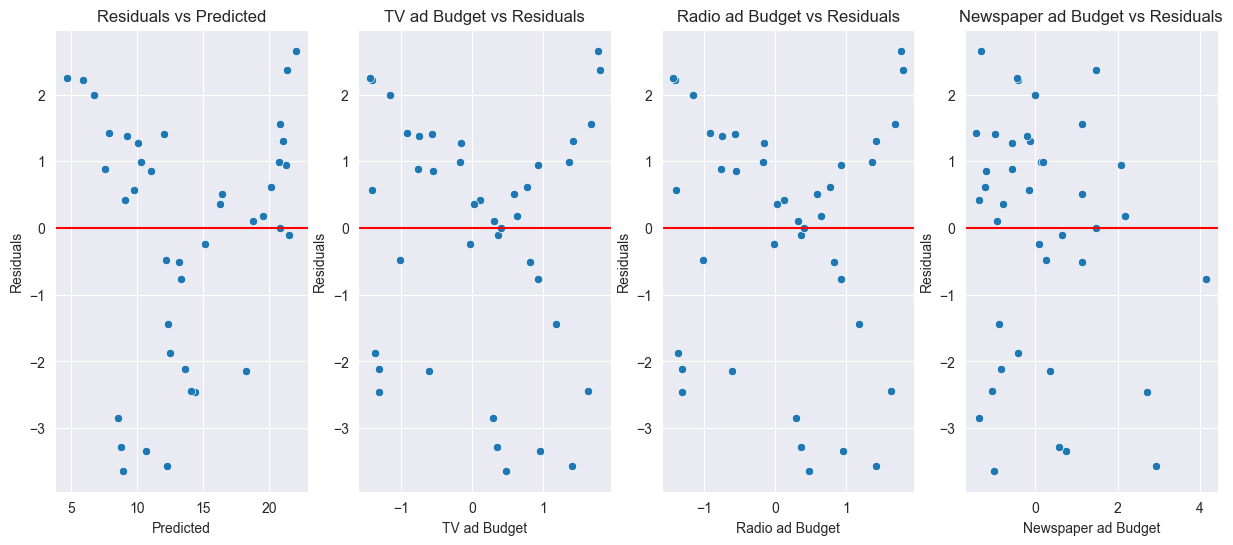

In [73]:
print_residuals(ols, X_test, y_test)
print_residuals(lasso, X_test, y_test)
print_residuals(ridge, X_test, y_test)
print_residuals(elasticnet, X_test, y_test)
# Doesn't seems to be a lot of pattern here (maybe im wrong) But at this stage, we claim that the linear hypothesis is confirmed because:
# 1. The R2 is pretty good
# 1. The residual per each feature as well as predicted value doesn't seems to have any pattern, so there's no missing polynomial feature

In [86]:
# We also print residuals in histogram
def plot_residuals_hist(model, X_test, y_test):
    plt.figure(figsize=(4,4))
    sns.histplot(data=(model.predict(X_test)-y_test), bins=40, kde=True)
    plt.axvline(x=0, color='r')
    plt.title("Residuals histogram")

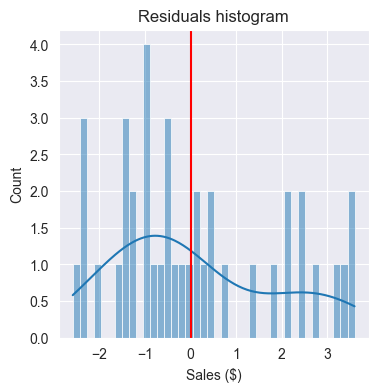

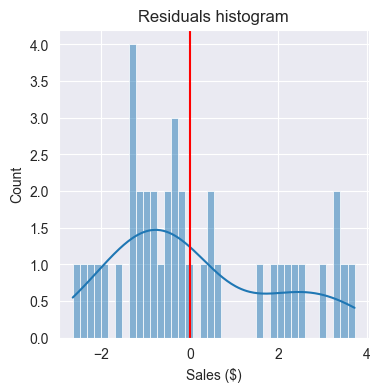

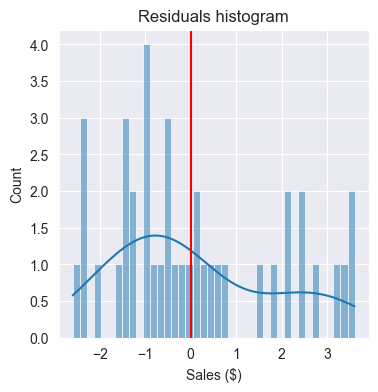

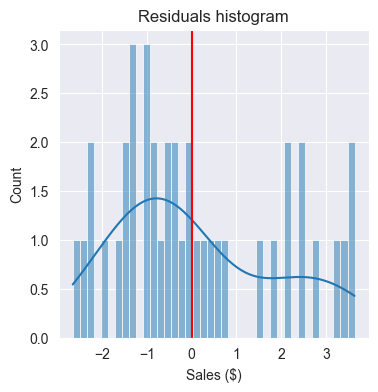

In [87]:
plot_residuals_hist(ols, X_test, y_test)
plot_residuals_hist(lasso, X_test, y_test)
plot_residuals_hist(ridge, X_test, y_test)
plot_residuals_hist(elasticnet, X_test, y_test)
# Here the graph doesn't sounds that normal distribution, this indicates there might be something missing from our regression (or say there can be some other polynomial feature?)

# Part 6 Which factor is strongest

In [91]:

ols_scaler_factor = ols['scaler'].scale_
lasso_scaler_factor = lasso['scaler'].scale_
ridge_scaler_factor = ridge['scaler'].scale_
elasticnet_scaler_factor = elasticnet['scaler'].scale_

ols_coef = ols['ols'].coef_
lasso_coef = lasso['lasso'].coef_
ridge_coef = ridge['ridge'].coef_
elasticnet_coef = elasticnet['elasticnet'].coef_

print(f"ols scaled coefficient: TV: {ols_coef[0]/ols_scaler_factor[0]}, Radio: {ols_coef[1]/ols_scaler_factor[1]}, Newspaper: {ols_coef[2]/ols_scaler_factor[2]}")
print(f"lasso scaled coefficient: TV: {lasso_coef[0]/lasso_scaler_factor[0]}, Radio: {lasso_coef[1]/lasso_scaler_factor[1]}, Newspaper: {lasso_coef[2]/lasso_scaler_factor[2]}")
print(f"ridge scaled coefficient: TV: {ridge_coef[0]/ridge_scaler_factor[0]}, Radio: {ridge_coef[1]/ridge_scaler_factor[1]}, Newspaper: {ridge_coef[2]/ridge_scaler_factor[2]}")
print(f"elasticnet scaled coefficient: TV: {elasticnet_coef[0]/elasticnet_scaler_factor[0]}, Radio: {elasticnet_coef[1]/elasticnet_scaler_factor[1]}, Newspaper: {elasticnet_coef[2]/elasticnet_scaler_factor[2]}")


ols scaled coefficient: TV: 0.0447295174687163, Radio: 0.1891950542343767, Newspaper: 0.0027611143413672173
lasso scaled coefficient: TV: 0.04405746949083199, Radio: 0.18650058956756274, Newspaper: 0.0006398949771710134
ridge scaled coefficient: TV: 0.044702632977276016, Radio: 0.18906542053738445, Newspaper: 0.0027981199088189636
elasticnet scaled coefficient: TV: 0.044384858105267024, Radio: 0.18759403199343938, Newspaper: 0.0029074047271871128


In [96]:
# From the comparison above, we wee that tv have a scaled factor of 0.04, radio have a scaled factor 0.18 and newspaper have a scaled factor 0.002. This shows that per each dollar spend, radio will likely to generate most return, which is much larger than TV and newspaper. Now lets compare the coefficient directly to see how different model behave:

print(f"ols coef: {ols_coef}")
print(f"lasso coef: {lasso_coef}")
print(f"ridge coef: {ridge_coef}")
print(f"elasticnet coef: {elasticnet_coef}")

# we realise that despite lasso that kinda eliminate the factor of newspaper, which has little relevance compare to other such as TV, all other factors are close to each other.
# Seems like elastic net choose a balance between them
print(f"elasticnet alpha: {elasticnet['elasticnet'].alpha_}, {elasticnet['elasticnet'].l1_ratio_}")

ols coef: [3.76419618 2.79230665 0.05597551]
lasso coef: [3.70764022 2.75253938 0.01297246]
ridge coef: [3.76193372 2.7903934  0.05672572]
elasticnet coef: [3.73519149 2.76867736 0.05894123]
elasticnet alpha: 0.012763206936910467, 0.5


# Part 7 Learning curve
Although we get almost 0.9 r2 for all models, we still need to plot the learning curve, to avoid we got a lucky split.

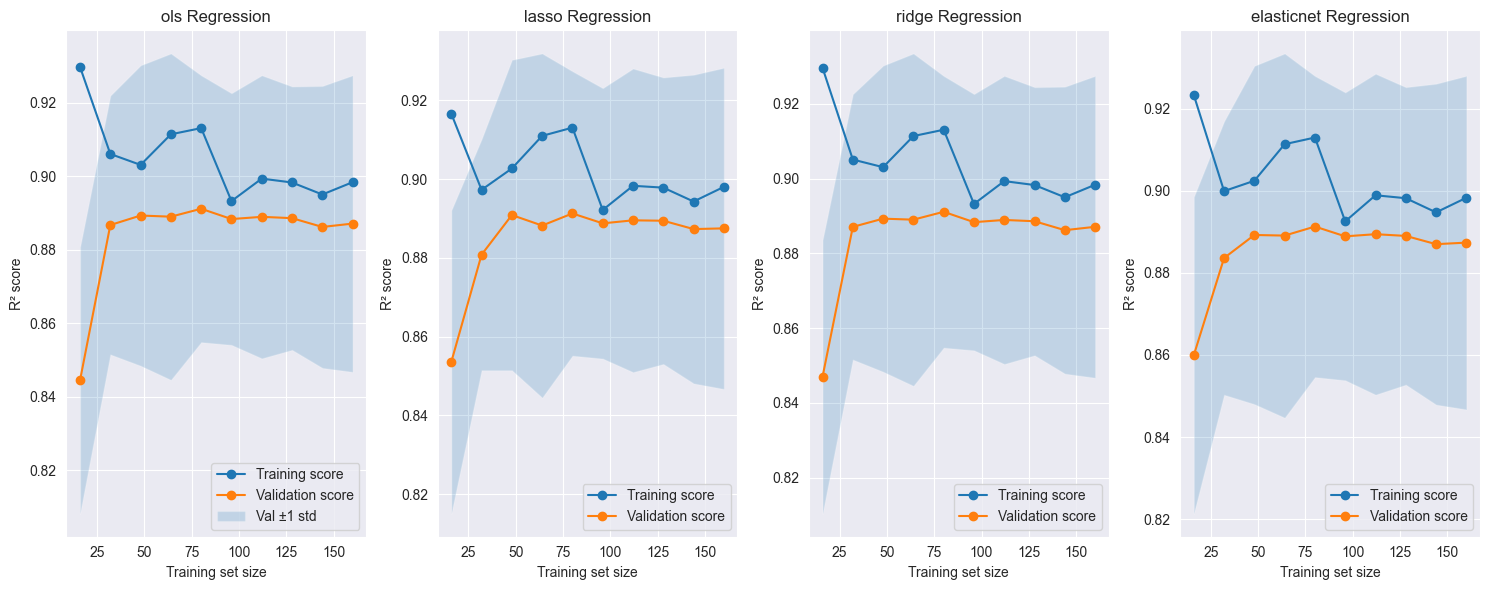

In [108]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import learning_curve
models = {
    'ols': make_pipeline(StandardScaler(), LinearRegression()),
    'lasso': make_pipeline(StandardScaler(), LassoCV()),
    'ridge': make_pipeline(StandardScaler(), RidgeCV()),
    'elasticnet': make_pipeline(StandardScaler(), ElasticNetCV()),
}

plt.figure(figsize=(15,6))
for i, (name, model) in enumerate(models.items(), 1):
    train_sizes, train_score, val_scores = learning_curve(
        estimator=model,
        X=X,
        y=y,
        scoring='r2',
        cv=5,
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10)
    )
    train_score_mean = np.mean(train_score, axis=1)
    val_score_mean = np.mean(val_scores, axis=1)
    val_score_std = np.std(val_scores, axis=1)
    plt.subplot(1, 4, i)
    plt.plot(train_sizes, train_score_mean, 'o-', label='Training score')
    plt.plot(train_sizes, val_score_mean, 'o-', label='Validation score')
    plt.fill_between(train_sizes, val_score_mean - val_score_std, val_score_mean + val_score_std,alpha=0.2, label="Val ±1 std" if i==1 else None)
    plt.title(f"{name} Regression")
    plt.xlabel("Training set size")
    plt.ylabel("R² score")
    plt.legend()
plt.tight_layout()
plt.show()

In [107]:
# We see that both training and testing r2 converge around 0.88+ after just 50 test samples, which demonstrate that the model works pretty well.

array([0.9233053 , 0.89990191, 0.90242208, 0.91132208, 0.91294764,
       0.89252998, 0.89888718, 0.89817361, 0.89472196, 0.89828358])

# GPT feedback
## ElasticNet Hyperparameter Search
- In your notebook, ElasticNet probably used defaults (alpha=1.0, l1_ratio=0.5).
- With small datasets, the default may look almost identical to Ridge/Lasso unless tuned.
- Feedback: use ElasticNetCV (with a grid of alphas and l1_ratio values). You’ll likely see subtle differences.

## Metrics Variety
- You focused on R² (and residual visuals). Adding RMSE and MAE would give a fuller picture of absolute error magnitudes.
- That also helps spot if one model is consistently biased.

## Histogram Interpretation
- You noted residuals weren’t perfectly normal. That’s true, but for predictive performance, normality isn’t required — independence and no strong heteroscedasticity matter more.
- I’d phrase it as: “Residuals deviate from normality, which might suggest nonlinear relationships, but variance looks roughly stable, so linear regression is still reasonable.”

## Coefficient Interpretation

- Since you scaled data for Ridge/Lasso/ElasticNet, comparing raw coefficients between models is tricky.
- Suggestion: after fitting, inverse-transform coefficients back to the original scale (divide by scaler.scale_). Then compare magnitudes to interpret which ad channel has the strongest effect.

## Cross-validation vs Single Split
- Right now you used a single train/test split. With such a small dataset (~200 rows), results may swing.
- A cross_val_score comparison table would make conclusions more robust.

In [109]:
# --- ElasticNetCV: pick alpha and l1_ratio via CV ---
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Use your existing train/test split: X_train, X_test, y_train, y_test
enet_cv = make_pipeline(
    StandardScaler(),
    ElasticNetCV(
        alphas=np.logspace(-4, 2, 100),    # log-spaced alphas
        l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.9], # try a few mixes
        cv=5,
        max_iter=20000,
        random_state=42
    )
)
enet_cv.fit(X_train, y_train)

# Pull tuned params from the inner ElasticNetCV step
enet = enet_cv.named_steps["elasticnetcv"]
print("Best alpha      :", enet.alpha_)
print("Best l1_ratio   :", enet.l1_ratio_)
print("CV MSE (mean)   :", -np.mean(enet.mse_path_.min(axis=0)))

# Hold-out test performance
y_pred = enet_cv.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)
print(f"Test: R2={r2:.3f}, RMSE={rmse:.3f}, MAE={mae:.3f}")


Best alpha      : 0.061359072734131756
Best l1_ratio   : 0.9
CV MSE (mean)   : -9.114069599872554
Test: R2=0.898, RMSE=1.790, MAE=1.461


/Users/wujizhu/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [110]:
import pandas as pd
from sklearn.model_selection import RepeatedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler

cv_outer = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

models = {
    # OLS (no tuning)
    "OLS": Pipeline([
        ("scaler", StandardScaler(with_mean=False)),  # keep features comparable; with_mean=False avoids issues if sparse
        ("model", LinearRegression())
    ]),
    # Ridge with inner CV over alphas
    "RidgeCV": Pipeline([
        ("scaler", StandardScaler()),
        ("model", RidgeCV(alphas=np.logspace(-4, 4, 50), cv=5))
    ]),
    # Lasso with inner CV
    "LassoCV": Pipeline([
        ("scaler", StandardScaler()),
        ("model", LassoCV(alphas=np.logspace(-4, 2, 80), max_iter=20000, cv=5, random_state=42))
    ]),
    # ElasticNet with inner CV over alpha & l1_ratio
    "ElasticNetCV": Pipeline([
        ("scaler", StandardScaler()),
        ("model", ElasticNetCV(alphas=np.logspace(-4, 2, 80),
                               l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.9],
                               cv=5, max_iter=20000, random_state=42))
    ]),
}

scoring = {
    "r2": "r2",
    "neg_rmse": "neg_root_mean_squared_error",
    "neg_mae": "neg_mean_absolute_error",
}

rows = []
for name, est in models.items():
    cvres = cross_validate(est, X, y, cv=cv_outer, scoring=scoring, n_jobs=-1, return_train_score=False)
    rows.append({
        "Model": name,
        "R2_mean":  np.mean(cvres["test_r2"]),
        "R2_std":   np.std(cvres["test_r2"]),
        "RMSE_mean": -np.mean(cvres["test_neg_rmse"]),
        "RMSE_std":  np.std(-cvres["test_neg_rmse"]),
        "MAE_mean":  -np.mean(cvres["test_neg_mae"]),
        "MAE_std":   np.std(-cvres["test_neg_mae"]),
    })

perf_table = pd.DataFrame(rows).sort_values(by="RMSE_mean")
display(perf_table.style.format({
    "R2_mean": "{:.3f}", "R2_std": "{:.3f}",
    "RMSE_mean": "{:.3f}", "RMSE_std": "{:.3f}",
    "MAE_mean": "{:.3f}", "MAE_std": "{:.3f}",
}))


,Model,R2_mean,R2_std,RMSE_mean,RMSE_std,MAE_mean,MAE_std
2,LassoCV,0.882,0.050,1.711,0.232,1.293,0.125
0,OLS,0.881,0.052,1.711,0.241,1.292,0.132
3,ElasticNetCV,0.881,0.050,1.712,0.232,1.293,0.124
1,RidgeCV,0.881,0.051,1.713,0.239,1.294,0.129
